In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import (
    f1_score, accuracy_score, precision_score, confusion_matrix, 
    classification_report, make_scorer, ConfusionMatrixDisplay, 
)


## Data

Simulamos un dataset de clasificación con sklearn.

In [2]:
X, y = make_classification(
    n_samples=5_000, n_features=10, n_informative=2, n_redundant=8, n_classes=2,
	n_clusters_per_class=2, weights=[0.6, 0.4], flip_y=0.1, class_sep=0.8, 
    random_state=42)

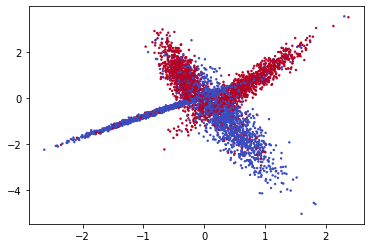

In [3]:
# plot features and target
plt.scatter(X[:, 0], X[:, 1], c=y, s=2, cmap='coolwarm')
plt.show()

## Ajuste de hiperparámetros

Buscamos un _buen_ Random Forest con grid search y K-fold Cross-Validation.

Para simplificar, solo vamos a hacer la búsqueda sobre pocos valores de un solo hiperparámetro.

In [4]:
param_grid = [
  {'min_samples_leaf': [5, 10, 50, 100, 1000]},
]

In [5]:
# param_grid = [
#   {
#     'clf': [LogisticRegression(max_iter=1000)],
#     'clf__l1': [...]
# },
#   {
#     'clf': [RandomForest()],
#     'clf__min_samples_leaf': [5, 10, 50, 100, 1000]
# },
# ]        

Definimos una matriz de costos arbitraria que suponemos puede ser de interés para el problema.

In [6]:
# filas: y, cols: y_pred
cost_matrix = np.array([
    [0, 1], # TRUE NEGATIVE, FALSE POSITIVE
    [5, 0], # FALSE NEGATIVE, TRUE POSITIVE
]) 

def gain_function(
    y: np.ndarray, y_pred: np.ndarray, cost_matrix: np.ndarray
) -> float:
    return -np.sum(cost_matrix[y, y_pred])

In [7]:
# ejemplo de uso:
print(
    gain_function([1,1,1], [0,0,0], cost_matrix), # real:1 , pred:0
    gain_function([0,0,0], [1,1,1], cost_matrix), # real:0 , pred:1
)

-15 -3


Definimos las métricas con las que queremos evaluar los modelos en los sets de validación. 

En principio nos va a interesar un modelo que sea bueno "globalmente" i.e. que tenga buena capacidad de discriminar entre 0s y 1s.

También guardamos el "gain" (costo negativo) para hacer comparaciones más adelante.

In [8]:
scoring = {
    "AUC": "roc_auc",
    "Gain": make_scorer(gain_function, cost_matrix=cost_matrix)
}

In [9]:
rf = RandomForestClassifier(n_estimators=200, max_features="sqrt", random_state=0)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
grid_search = GridSearchCV(rf, param_grid, cv=skf, scoring=scoring, refit="AUC", verbose=3)

_ = grid_search.fit(X, y)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END min_samples_leaf=5; AUC: (test=0.889) Gain: (test=-476.000) total time=  14.6s
[CV 2/5] END min_samples_leaf=5; AUC: (test=0.876) Gain: (test=-437.000) total time=   8.0s
[CV 3/5] END min_samples_leaf=5; AUC: (test=0.892) Gain: (test=-436.000) total time=  10.8s
[CV 4/5] END min_samples_leaf=5; AUC: (test=0.873) Gain: (test=-523.000) total time=  22.7s
[CV 5/5] END min_samples_leaf=5; AUC: (test=0.896) Gain: (test=-529.000) total time=  23.9s
[CV 1/5] END min_samples_leaf=10; AUC: (test=0.897) Gain: (test=-454.000) total time=  18.3s
[CV 2/5] END min_samples_leaf=10; AUC: (test=0.876) Gain: (test=-475.000) total time=   9.8s
[CV 3/5] END min_samples_leaf=10; AUC: (test=0.896) Gain: (test=-461.000) total time=  18.0s
[CV 4/5] END min_samples_leaf=10; AUC: (test=0.877) Gain: (test=-524.000) total time=  17.6s
[CV 5/5] END min_samples_leaf=10; AUC: (test=0.901) Gain: (test=-506.000) total time=  19.4s
[CV 1/5] END mi

Analizamos los resultados y conservamos el mejor modelo encontrado.

In [9]:
print(grid_search.best_params_)

{'min_samples_leaf': 50}


In [10]:
# results to dataframe
df_cv = pd.DataFrame(grid_search.cv_results_)

In [11]:
df_cv[["params","mean_test_AUC", "mean_test_Gain"]]

,params,mean_test_AUC,mean_test_Gain
0,{'min_samples_leaf': 5},0.885434,-480.2
1,{'min_samples_leaf': 10},0.889456,-484.0
2,{'min_samples_leaf': 50},0.894296,-527.8
3,{'min_samples_leaf': 100},0.889886,-610.0
4,{'min_samples_leaf': 1000},0.797436,-635.8


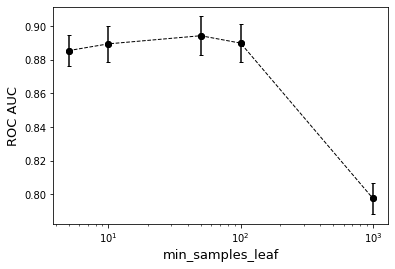

In [12]:
# plot ROC auc as function of min_samples_leaf with x log scale and error bars
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(
    df_cv['param_min_samples_leaf'], df_cv['mean_test_AUC'],
    marker='o', linestyle='--', linewidth=1, color='black')
ax.errorbar(
    df_cv['param_min_samples_leaf'], df_cv['mean_test_AUC'],
    yerr=df_cv['std_test_AUC'], fmt='o', color='black', capsize=2)
ax.set_xscale('log')
plt.xlabel('min_samples_leaf', fontsize=13)
plt.ylabel('ROC AUC', fontsize=13)
plt.show()

In [13]:
print("So far:")
print(f"Best Gain = {df_cv['mean_test_Gain'].max():.1f}")
print(f"Best AUC = {df_cv['mean_test_AUC'].max():.3f}")

So far:
Best Gain = -480.2
Best AUC = 0.894


## Punto de corte

Para el mejor modelo según AUC, buscamos los puntos de corte que maximizan f1_score, accuracy y el Gain.

Usamos los mismos folds que usamos para optimizar los hiperparámetros.

In [14]:
def to_labels(probas, threshold):
	return (probas >= threshold).astype('int')

In [15]:
clf = grid_search.best_estimator_
thresholds = np.linspace(0, 1, 500+1)

In [16]:
results = []
for i, (train_index, val_index) in enumerate(skf.split(X, y)):
    X_train, X_val = X[val_index], X[val_index]
    y_train, y_val = y[val_index], y[val_index]
    clf.fit(X_train, y_train)
    probas = clf.predict_proba(X_val)[:, 1]
    for threshold in thresholds:
        y_pred = to_labels(probas, threshold)
        result = {
            'f1': f1_score(y_val, y_pred),
            'accuracy': accuracy_score(y_val, y_pred),
            'gain': gain_function(y_val, y_pred, cost_matrix),
            'precision': precision_score(y_val, y_pred, zero_division=0),
            'threshold': threshold,
            'fold': i,
        }
        results.append(result)

In [17]:
# convert results to a DataFrame
df_threshold = pd.DataFrame(results)
# get mean and standard error by threshold
df_threshold = df_threshold.groupby('threshold').agg(
    {'f1': ['mean', 'std'], 'accuracy': ['mean', 'std'], 'gain': ['mean', 'std'],
    'precision': ['mean', 'std']})
# flatten column names
df_threshold.columns = ['_'.join(col).strip() for col in df_threshold.columns.values]
df_threshold.reset_index(inplace=True)

In [18]:
def plot_performance_by_threshold(df_results, score_name):
    fig, ax = plt.subplots(figsize=(6,2))
    x = df_results['threshold']
    y = df_results[score_name + '_mean']
    std = df_results[score_name + '_std']
    ax.plot(x, y, marker=None, linestyle='--', linewidth=1, color='black')
    ax.fill_between(x, y - std, y + std, color='black', alpha=0.2)
    best_threshold = x.iloc[np.argmax(y)]
    best_score = y.max()
    plt.axvline(x=best_threshold, linestyle='--', color='red')
    plt.title(f"Threshold={best_threshold:.3f}, value={best_score:.3f}")
    plt.xlabel('threshold', fontsize=13)
    plt.ylabel(score_name, fontsize=13)


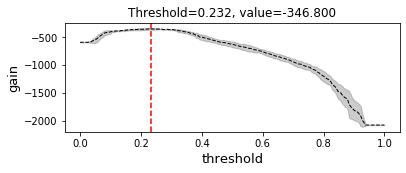

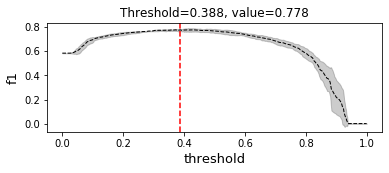

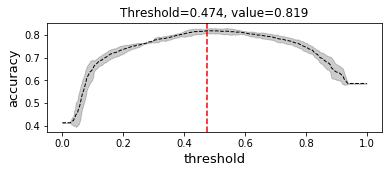

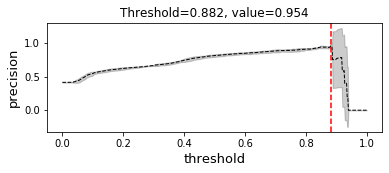

In [19]:
plot_performance_by_threshold(df_threshold, 'gain')
plt.show()

plot_performance_by_threshold(df_threshold, 'f1')
plt.show()

plot_performance_by_threshold(df_threshold, 'accuracy')
plt.show()

plot_performance_by_threshold(df_threshold, 'precision')
plt.show()

Visualizamos la matriz de confusion y métricas de clasificación para el modelo y threshold con mejor gain.  

Lo hacemos sobre todos los datos. En un caso real lo podríamos hacer sobre el set de test.

In [20]:
clf = grid_search.best_estimator_
threshold = df_threshold['threshold'].iloc[df_threshold['gain_mean'].idxmax()]

In [21]:
y_pred_probas = clf.predict_proba(X)[:, 1]
y_pred = to_labels(y_pred_probas, threshold)

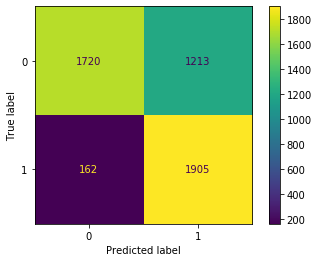

In [22]:
# plot confusion matrix
cm = confusion_matrix(y, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()

In [23]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.59      0.71      2933
           1       0.61      0.92      0.73      2067

    accuracy                           0.73      5000
   macro avg       0.76      0.75      0.72      5000
weighted avg       0.79      0.72      0.72      5000



## Otras herramientas de evaluación

### Hosmer-Lemeshow Plot

In [24]:
df_pred = pd.DataFrame({
    'y': y,
    'y_pred': y_pred,
    'y_pred_probas': y_pred_probas
})

In [25]:
def hosmer_lemeshow_plot(df, bins=10, type="uniform"):
    # cut proba in equal length bins
    if type == "uniform":
        df['bin'] = pd.cut(df_pred['y_pred_probas'], bins=bins, labels=False)
    # cut proba in equal n bins
    elif type == "quantile":
        df['bin'] = pd.qcut(df_pred['y_pred_probas'], q=bins, labels=False)
    # mean score by bin
    df_bin = df.groupby('bin').agg(
        score=("y_pred_probas", "mean"), 
        target=("y", "mean"),
        n=("y", "count"))
    # scatter plot with point size according to count
    plt.scatter(df_bin['score'], df_bin['target'], s=df_bin['n'], alpha=0.5)
    # add text with count for each bin
    for i, row in df_bin.iterrows():
        plt.text(row['score'], row['target'], int(row['n']), fontsize=10, 
        color='black', va="bottom", ha="right")
    # add diagonal line
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('score')
    plt.ylabel('target')

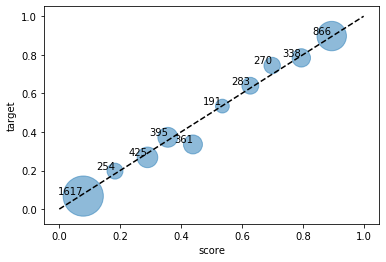

In [26]:
hosmer_lemeshow_plot(df_pred, bins=10, type="uniform")
plt.show()

### Violin plot

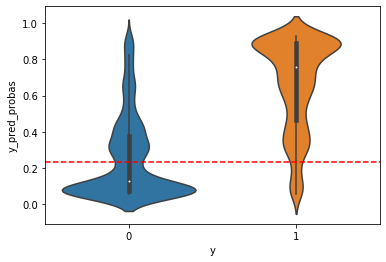

In [27]:
# violin plot with a horizontal line for the best threshold
ax = sns.violinplot(x="y", y="y_pred_probas", data=df_pred)
ax.axhline(y=threshold, color='red', linestyle='--')
plt.show()
